In [1]:
import argparse
import os
import shutil

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from datasets_prep.dataset import create_dataset
#from diffusion import sample_from_model, sample_posterior, \
#    q_sample_pairs, get_time_schedule, \
#    Posterior_Coefficie
#nts, Diffusion_Coefficients
#from DWT_IDWT.DWT_IDWT_layer import DWT_2D, IDWT_2D
#from pytorch_wavelets import DWTForward, DWTInverse
from torch.multiprocessing import Process
from utils import init_processes, copy_source, broadcast_params
import yaml

from ldm.util import instantiate_from_config
from omegaconf import OmegaConf

/home/kotomiya/anaconda3/envs/ddgan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def load_model_from_config(config_path, ckpt):
    print(f"Loading model from {ckpt}")
    config = OmegaConf.load(config_path)
    pl_sd = torch.load(ckpt, map_location="cpu")
    #global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model = model.first_stage_model
    model.cuda()
    model.eval()
    del m
    del u
    del pl_sd
    return model

def grad_penalty_call(args, D_real, x_t):
    grad_real = torch.autograd.grad(
        outputs=D_real.sum(), inputs=x_t, create_graph=True
    )[0]
    grad_penalty = (
        grad_real.view(grad_real.size(0), -1).norm(2, dim=1) ** 2
    ).mean()

    grad_penalty = args.r1_gamma / 2 * grad_penalty
    grad_penalty.backward()

device = "cuda:0"

In [ ]:
from ldm.util import instantiate_from_config
config_path = "./autoencoder/config/cifar10_16x16x4.yaml"
ckpt_path = "./autoencoder/weight/kl-f2.ckpt"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

AutoEncoder = instantiate_from_config(config['model'])


checkpoint = torch.load(ckpt_path, map_location=device)
AutoEncoder.load_state_dict(checkpoint['state_dict'])
AutoEncoder.eval()
AutoEncoder.to(device)

In [11]:
from ldm.util import instantiate_from_config
config_path = "./autoencoder/config/vq-f4.yaml"
ckpt_path = "./autoencoder/weight/vq-f4.ckpt"
with open(config_path, 'r') as file:
    config = yaml.safe_load(file)

AutoEncoder = instantiate_from_config(config['model'])


checkpoint = torch.load(ckpt_path, map_location=device)
AutoEncoder.load_state_dict(checkpoint['state_dict'])
AutoEncoder.eval()
AutoEncoder.to(device)

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


/home/kotomiya/anaconda3/envs/ddgan/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/kotomiya/anaconda3/envs/ddgan/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.


VQModelInterface(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down): ModuleList(
      (0): Module(
        (block): ModuleList(
          (0-1): 2 x ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          )
        )
        (attn): ModuleList()
        (downsample): Downsample(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2))
        )
      )
      (1): Module(
        (block): ModuleList(
          (0): ResnetBlock(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            

In [15]:
import os

import torch
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import CIFAR10, STL10

from datasets_prep.coco import CustomCocoCaptions
size = 128
datadir ="./data/coco"
train_transform = transforms.Compose([
    transforms.Resize(size),
    transforms.transforms.CenterCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = CustomCocoCaptions(
    name="train2017",
    root=os.path.join(datadir, "train2017"),
    annFile=os.path.join(
    datadir, 'annotations', 'captions_train2017.json'),
    transform=train_transform)

data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=8,
                                          shuffle=False,
                                          num_workers=2,
                                          pin_memory=True,
                                          #sampler=train_sampler,
                                          drop_last=True
                                         )

loading annotations into memory...
Done (t=0.95s)
creating index...
index created!


In [16]:
from PIL import Image

In [17]:
tmp = iter(data_loader)
x, y = next(tmp)

In [18]:
device = "cuda"
scale_factor = 1.0
x0 = x.to(device, non_blocking=True)
with torch.no_grad():
    posterior = AutoEncoder.encode(x0)
    real_data = posterior.detach()
#print("MIN:{}, MAX:{}".format(real_data.min(), real_data.max()))
real_data = real_data / scale_factor #300.0  # [-1, 1]

In [19]:
x0 = x.to(device)
print(x0.shape)
with torch.no_grad():
    posterior = AutoEncoder.encode(x0)
    real_data = posterior.detach()
print(real_data.shape)

torch.Size([8, 3, 128, 128])
torch.Size([8, 3, 32, 32])


In [20]:
posterior.shape

torch.Size([8, 3, 32, 32])

['Colorful dishes holding meat, vegetables, fruit, and bread.', 'A giraffe standing next to a forest filled with trees.', 'A flower vase is sitting on a porch stand.', 'A lone zebra grazing in some green grass.', 'A woman with an umbrella near the sea', 'A dog sleeping on a show rack in the shoes.', 'Two costumed horse riders make their horses stand on their hind legs.', 'They are brave for riding in the jungle on those elephants.']


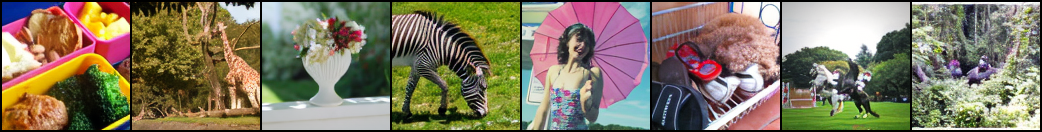

In [21]:
real_data *= scale_factor #300
with torch.no_grad():
    real_data = AutoEncoder.decode(real_data)

real_data = (torch.clamp(real_data, -1, 1) + 1) / 2  # 0-1 

torchvision.utils.save_image(
    real_data, os.path.join("./", 'real_data.png'))
imgPIL = Image.open("./real_data.png")  # 画像読み込み

print(y)
imgPIL.show()  # 画像表示

In [ ]:
dataset = CIFAR10("./data/cifar-10", train=True, transform=transforms.Compose([
            transforms.Resize(32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]), download=True)
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=1,           
                                         )

In [ ]:
!bash lab_run.sh cifar10 train 1